In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import pickle
import random
import cv2

2022-09-06 04:15:23.683303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 04:15:23.683372: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
np.random.seed(2222)

In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data=pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data=pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data=pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
all = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]
print('X_train percent = ',round(X_train.shape[0]/all*100, 2))
print('X_val percent = ',round(X_val.shape[0]/all*100, 2))
print('X_test percent = ',round(X_test.shape[0]/all*100, 2))

X_train percent =  67.13
X_val percent =  8.51
X_test percent =  24.36


In [8]:
assert(X_train.shape[0]==y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_val.shape[0]==y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_test.shape[0]==y_test.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_train.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_test.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_val.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

In [9]:
data=pd.read_csv('german-traffic-signs/signnames.csv')

In [10]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


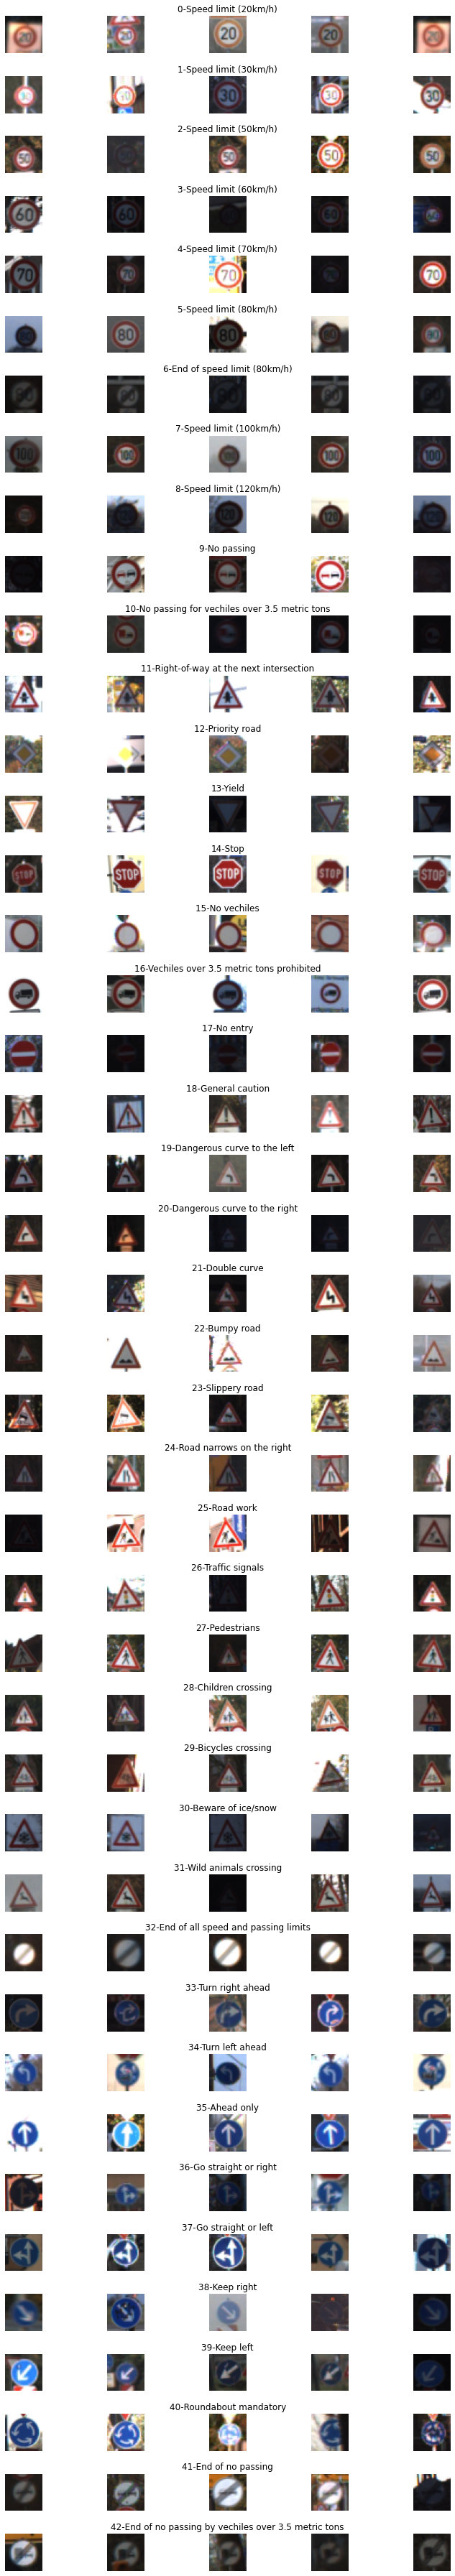

In [12]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(10, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-'+row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


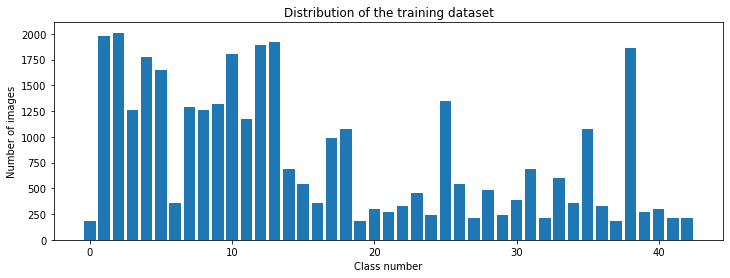

In [13]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [14]:
np.std(num_of_samples)

619.4201837045108

In [15]:
print(np.max(num_of_samples), np.min(num_of_samples))

2010 180


## preprocessing

(32, 32, 3)
31


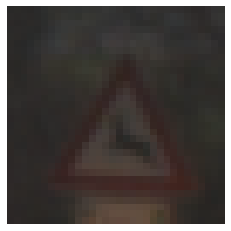

In [16]:
plt.imshow(X_train[222])
plt.axis('off')
print(X_train[222].shape)
print(y_train[222])

### convert to gray

(32, 32)


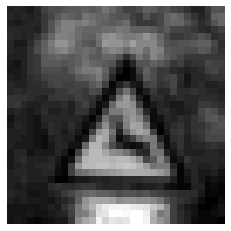

In [17]:
def grayscale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

img = grayscale(X_train[222])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

### histogram equalization

(32, 32)


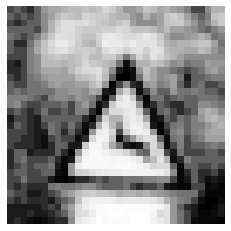

In [18]:
def equalize(img):
    # equalizeHist funciont only accept gray images
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

img = equalize(img)
print(img.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [19]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train=np.array(list(map(preprocessing, X_train)))
X_val=np.array(list(map(preprocessing, X_val)))
X_test=np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


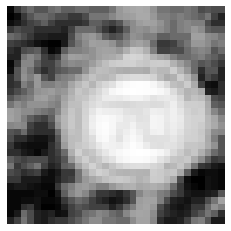

In [23]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)
plt.show()

In [24]:
X_train=X_train.reshape(34799, 32, 32, 1)
X_test=X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val=X_val.reshape(X_val.shape[0], 32, 32, 1)

In [25]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [26]:
y_train=to_categorical(y_train, 43)
y_test=to_categorical(y_test, 43)
y_val=to_categorical(y_val, 43)